In [5]:
###The Hot Neighbourhood Predictor, code written in python 2.7 in jupyter
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#read the Crime Data or SF
CrimeData = pd.read_csv("Map_Crime_Incidents.csv")
#Read the price data
PriceDatabyZipcode = pd.read_csv("Zip_MedianValuePerSqft_AllHomes.csv")

#Reorganize the price data
#Reshape so that years are values and not rows
SFPriceDatabyZipcode2 = pd.melt(PriceDatabyZipcode, id_vars=["RegionID", "RegionName", "City",
                                             "State", "Metro", "CountyName", "SizeRank"], 
                  var_name="Date", value_name="Value")
#Limit to SF only
SFPriceData = SFPriceDatabyZipcode2[SFPriceDatabyZipcode2['City']=='San Francisco']
#Make a datetume object out of Date
SFPriceData['Date2'] = pd.to_datetime(SFPriceData['Date'],infer_datetime_format=True)

#drop some columns
#RegionName is zipcode
SFPriceData2 = SFPriceData[['Date2', 'Metro', 'CountyName', 'Value', 'RegionName']]
SFPriceData2['Year'] = SFPriceData2['Date2'].apply(lambda x: x.year) 
SFPriceData2['Month'] = SFPriceData2['Date2'].apply(lambda x: x.month)


#calculate difference in price between jan and jan next year for each year in data
 
#take only month of January
SFPriceData2Yearly = SFPriceData2[SFPriceData2['Month']==1]

#compute differnce between each two consequitive years
SFPriceData2YearlyWork = SFPriceData2Yearly[['RegionName', 'Year', 'Value']]

#drop years prior to 2004
SFPriceData2YearlyWork= SFPriceData2YearlyWork[SFPriceData2YearlyWork['Year'] >= 2004]
SFPriceData2YearlyPivot = SFPriceData2YearlyWork.pivot(index='RegionName', columns='Year', values='Value')

for year in SFPriceData2YearlyPivot.columns:
    if year -1 in SFPriceData2YearlyPivot.columns:
        SFPriceData2YearlyPivot[str(year)+'-'+str(year-1)] = SFPriceData2YearlyPivot[year] - SFPriceData2YearlyPivot[year-1]
        
SFPriceData2YearlyPivot['Zipcode'] = SFPriceData2YearlyPivot.index
ByZipcodeYearlyBack = pd.melt(SFPriceData2YearlyPivot, id_vars=["Zipcode"], 
                  var_name="Year", value_name="Value")

for year in range(2004, 2017):
    ByZipcodeYearlyBack = ByZipcodeYearlyBack[ByZipcodeYearlyBack['Year']!=year]

ByZipcodeYearlyBack['Year']=ByZipcodeYearlyBack['Year'].apply(lambda x: int(str.split(x, '-')[0]))

#compute average change by year
AverageChangePerYEarZip = ByZipcodeYearlyBack.groupby(['Year'])['Value'].mean()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
#Geocoder
#get zipcodes from coordinates
import geocoder
import ast
#careful- this wastes requests!
#comment out to rum
google_key = 'my_key'

X=np.linspace(-122.513642064,-122.389940,50)
Y=np.linspace(37.7078790224,37.806995736979587,50)
d={}
for x in X:
    for y in Y:
        d[(y,x)]= geocoder.google([y,x],method='reverse',key=google_key).postal


In [ ]:
#save to a csv file
with open('zippzopp.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in d.items():
        writer.writerow([key, value])

In [6]:
import ast

LonLatToZipcode = pd.read_csv("zippzopp.csv")
LonLatToZipcode['location'] = LonLatToZipcode['location'].apply(lambda x: ast.literal_eval(x))
d = dict(zip(LonLatToZipcode['location'].values, LonLatToZipcode['zipcode'].values))
def zipCodifying(row):
    x=row['X']
    y=row['Y']
    upperX = -122.389940
    lowerX = -122.513642064
    upperY = 37.806995736979587 #37.818259
    lowerY = 37.7078790224
    cells = 50
    XX=np.linspace(lowerX, upperX, cells)
    YY=np.linspace(lowerY, upperY, cells)
    
    delx=(upperX-lowerX)/50
    dely=(upperY-lowerY)/50
    inx=int(((x-lowerX)-((x-lowerX)%delx))/delx)
    iny=int(((y-lowerY)-((y-lowerY)%dely))/dely)
    
    if iny > 49:
        iny = 49
    if inx > 49:
        inx = 49

    if inx>=0 and inx<=49 and iny>=0 and iny<=49:
        if inx < 49 and (abs(x-XX[inx]) > abs(x-XX[inx+1])):
            inx = inx+1
        if iny < 49 and (abs(y-YY[iny]) > abs(y-YY[iny+1])):
            iny = iny+1
        newx=XX[inx]
        newy=YY[iny]
        #find the closest zipcode to the left that matches
        while np.isnan(d[(newy, newx)]) and inx >0:
            inx = inx-1
            newx = XX[inx]
        #move downward to the closest zipcode that has a non nan value
        while np.isnan(d[(newy, newx)]) and iny >0:
            iny = iny-1
            newy = YY[iny]
        zipcode=d[(newy,newx)] 
    else:
        zipcode=0
        
    return zipcode
    
CrimeData['zipcode']=CrimeData.apply(zipCodifying,axis=1)
CrimeData = CrimeData[CrimeData['Y'] < 90]

In [7]:
#organize Crime Data a bit more
ListofCrimes=CrimeData['Category'].value_counts().index.values
CrimeData['Year'] = CrimeData['Date'].apply(lambda x: int(str.split(str.split(x,'/')[2],' ')[0]))


In [8]:
#get number of crimes of each type per year per zipcode
CrimeData_sub = CrimeData[['Descript', 'Year', 'zipcode']]
CrimeData_sub['Count'] = np.ones(CrimeData_sub.shape[0])
TotalPerZipcodePerYear = CrimeData_sub.groupby(['Year', 'zipcode'], as_index = False).agg({'Count': np.sum})
TotalPerYear = TotalPerZipcodePerYear.groupby(['Year'], as_index = False).agg({'Count': np.sum})

ZipNames=ByZipcodeYearlyBack['Zipcode'].value_counts().index.values


/Library/Python/2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
# beatMarket Returns 1 if the improvement in mean value of houses in the district between January 1st of (year-1) and 
#January 1st of year is over the mean improvement across districts
def beatMarket(zipcode,year):
    yearlyMean= ByZipcodeYearlyBack[ByZipcodeYearlyBack['Year']==year]['Value'].mean()
    selectZipYear = (ByZipcodeYearlyBack['Zipcode']==zipcode) & (ByZipcodeYearlyBack['Year']==year)
    ZipMean = ByZipcodeYearlyBack[selectZipYear]['Value'].values[0]
    if ZipMean > yearlyMean:
        return 1
    else:
        return 0 

In [10]:
#get everything into one Dataframe
CrimeDataSmall = CrimeData[['Category', 'zipcode', 'Date']]
CrimeDataSmall['Year'] = CrimeDataSmall['Date'].apply(lambda x: int(str.split(str.split(x,'/')[2],' ')[0]))
frame_data=[]
target = []
#business_data = []
m=0
numYears = 12 #there is data from 12 years
for i in ZipNames:
    #BusinessZip = BusinessChangePerYearZip[BusinessChangePerYearZip['Zipcode']== i]
    for j in range(numYears):
        target.append(beatMarket(i,2005+j))
        Row_of_data=[i,j+2003]
        All_in_Year=CrimeDataSmall[CrimeDataSmall['Year']==j+2003]['Category'].value_counts()
        select_condition = (CrimeDataSmall['zipcode']==i) &(CrimeDataSmall['Year']==j+2003)
        Crime_Counts_in_Year= CrimeDataSmall[select_condition]['Category'].value_counts()
        percentofallinyear=sum(Crime_Counts_in_Year)*(1.0)/len(CrimeDataSmall[CrimeDataSmall['Year']==j+2003])
        Row_of_data.append(percentofallinyear)
        for k in ListofCrimes:
            if k in Crime_Counts_in_Year.index:
                Row_of_data.append((Crime_Counts_in_Year[k]*(1.0)/sum(Crime_Counts_in_Year)))
            else: #if there was no crime of this type in that year and district append 0
                Row_of_data.append(0)
        #Row_of_data.append(BusinessChange['Change'].values[0])  
        #business_data.append(BusinessChange['Change'].values[0])
        frame_data.append(Row_of_data)
    m=m+1
CombinedData=pd.DataFrame(columns=['zipcode', 'year','percent of all in year'] +list(ListofCrimes))
for i in range(len(frame_data)):
        CombinedData.loc[i]=(frame_data[i])
        

/Library/Python/2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
#Remove means for same district across years
meansData= CombinedData.groupby(['zipcode']).mean()
def removeMean(row):
    for i in range(len(row)-2):
        mean=meansData[meansData.index==row[0]].values[0][i+1]
        row[i+2]=row[i+2]-mean
    return row

OriginalCombinedData = CombinedData.copy()
Newie=CombinedData.apply(removeMean,axis=1)

#dummies
m=0
datas=[]
numYears = 12 #there is data from 12 years
for i in ZipNames:
    #BusinessZip = BusinessChangePerYearZip[BusinessChangePerYearZip['Zipcode']== i]
    for j in range(numYears):
        Row=[0]*m+[1]+[0]*(len(ZipNames)-m-1)
        #BusinessChange = BusinessZip[BusinessZip['Year']==j+2003]
        #Row.append(BusinessChange['Change'].values[0])
        #Row.append(BusinessChange['Open'].values[0])
        #Row.append(BusinessChange['Closed'].values[0])
        datas.append(Row)
    m=m+1
dummies=pd.DataFrame(columns=list(ZipNames))
for i in range(len(datas)):
        dummies.loc[i]=(datas[i])
        
#Change in businesses

#for i in Zi
        
#Create train data
train=pd.concat([Newie.ix[:,2:],dummies],axis=1)


In [12]:
Newie.head()

,zipcode,year,percent of all in year,LARCENY/THEFT,OTHER OFFENSES,NON-CRIMINAL,ASSAULT,VEHICLE THEFT,DRUG/NARCOTIC,VANDALISM,...,LOITERING,SUICIDE,FAMILY OFFENSES,BAD CHECKS,BRIBERY,EXTORTION,"SEX OFFENSES, NON FORCIBLE",GAMBLING,PORNOGRAPHY/OBSCENE MAT,TREA
0,94158.0,2003.0,0.002000,-0.032292,0.007884,-0.018146,-0.002301,0.099177,-0.003778,-0.010246,...,0.000944,-0.00042,-0.000312,-0.000477,-0.000298,0.0,0.0,0.0,0.0,0.0
1,94158.0,2004.0,0.000404,-0.095535,0.024904,-0.001810,-0.003254,0.127356,0.000886,-0.006926,...,-0.000301,-0.00042,-0.000312,-0.000477,-0.000298,0.0,0.0,0.0,0.0,0.0
2,94158.0,2005.0,-0.000246,-0.059125,-0.007777,-0.018380,-0.019476,0.087017,0.014910,0.013186,...,-0.000301,-0.00042,-0.000312,-0.000477,-0.000298,0.0,0.0,0.0,0.0,0.0
3,94158.0,2006.0,-0.000896,-0.046731,0.007499,0.013703,0.013725,-0.002649,-0.004145,-0.020884,...,-0.000301,-0.00042,-0.000312,-0.000477,-0.000298,0.0,0.0,0.0,0.0,0.0
4,94158.0,2007.0,-0.000318,-0.001424,0.001351,-0.000847,0.006643,-0.047459,0.004975,0.013037,...,0.002068,-0.00042,-0.000312,-0.000477,-0.000298,0.0,0.0,0.0,0.0,0.0


0.656200846945
21.0


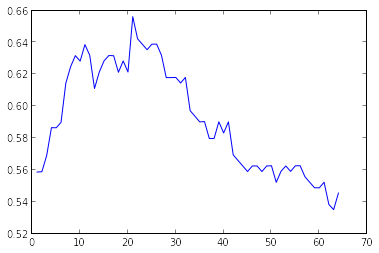

In [15]:
%matplotlib inline
#ZipNames=ByZipcodeYearlyBack['Zipcode'].value_counts().index.values

#Logistic Regression
#Check mean cross validation scores for various choices of feature selections for logistic regression
from sklearn import feature_selection
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.linear_model import *
import pylab

#x is [1,.....,len(train.columns)]
x =  np.linspace(1,len(train.columns),len(train.columns))
y=[]
clf=Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])
#select a+1 features every time and check prediction
for a in range(len(train.columns)):
    #select best a+1 features
    fs=feature_selection.SelectKBest(feature_selection.f_classif,k=a+1)
    #fit the data
    X_train=fs.fit_transform(train,target)
    #compute cross validation 5 times
    cv=KFold(len(train),5,shuffle=True, random_state=20)
    scores=cross_val_score(clf,X_train,target,cv=cv) #cross validation scores
    y.append(np.mean(scores))
pylab.plot(x,y)
print(max(y))
print x[np.array(y).argmax(axis=0)]

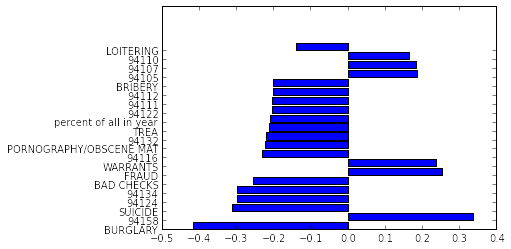

In [22]:
y_pos = np.arange(len(LCoefficients['Feature'].values))
plt.barh(y_pos, LCoefficients['L_Coef'].values)
plt.yticks(y_pos, LCoefficients['Feature'].values)
plt.savefig('LCoefficients.png', bbox_inches='tight')

In [16]:
fs=feature_selection.SelectKBest(feature_selection.f_classif,k=21) #21 features gives best result
X_train = fs.fit_transform(train,target)
scaler=StandardScaler().fit(X_train)
X=scaler.transform(X_train)
l=LogisticRegression().fit(X, target)

#mathch the F score to the crime
DataCoefficients = pd.DataFrame({'Variables': train.columns,'F_Scores': fs.scores_}) 
DataCoefficients = DataCoefficients.sort('F_Scores', ascending=[0]) #sort by F-Score

#mathch the L coefficient to the crime
ChosenFeatures=pd.Series(train.columns)[pd.Series(train.columns).
                                        apply(lambda x: x in set(DataCoefficients['Variables'].values[:21]))]
LCoefficients = pd.DataFrame({'Feature':ChosenFeatures, 'L_Coef':l.coef_[0]})
LCoefficients['LAbsValue'] = LCoefficients['L_Coef'].apply(lambda x: abs(x))
LCoefficients= LCoefficients.sort('LAbsValue', ascending = [0]) #sort


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [18]:
Newie['year'].value_counts()

2014.0    24
2013.0    24
2012.0    24
2011.0    24
2010.0    24
2009.0    24
2008.0    24
2007.0    24
2006.0    24
2005.0    24
2004.0    24
2003.0    24
Name: year, dtype: int64

In [20]:
#get prediction for 2016
#get everything into one Dataframe
CrimeDataSmall = CrimeData[['Category', 'zipcode', 'Date']]
CrimeDataSmall['Year'] = CrimeDataSmall['Date'].apply(lambda x: int(str.split(str.split(x,'/')[2],' ')[0]))
frame_data=[]
target = []
#business_data = []
for i in ZipNames:
    #BusinessZip = BusinessChangePerYearZip[BusinessChangePerYearZip['Zipcode']== i]
    #for j in range(numYears):
    #    target.append(beatMarket(i,2005+j))
        Row_of_data=[i,2015]
        All_in_Year=CrimeDataSmall[CrimeDataSmall['Year']==2015]['Category'].value_counts()
        select_condition = (CrimeDataSmall['zipcode']==i) &(CrimeDataSmall['Year']==2015)
        Crime_Counts_in_Year= CrimeDataSmall[select_condition]['Category'].value_counts()
        percentofallinyear=sum(Crime_Counts_in_Year)*(1.0)/len(CrimeDataSmall[CrimeDataSmall['Year']==2015])
        Row_of_data.append(percentofallinyear)
        for k in ListofCrimes:
            if k in Crime_Counts_in_Year.index:
                Row_of_data.append((Crime_Counts_in_Year[k]*(1.0)/sum(Crime_Counts_in_Year)))
            else: #if there was no crime of this type in that year and district append 0
                Row_of_data.append(0)
        #Row_of_data.append(BusinessChange['Change'].values[0])  
        #business_data.append(BusinessChange['Change'].values[0])
        frame_data.append(Row_of_data)
    #m=m+1
CombinedData_2015=pd.DataFrame(columns=['zipcode', 'year','percent of all in year'] +list(ListofCrimes))
for i in range(len(frame_data)):
        CombinedData_2015.loc[i]=(frame_data[i])
        
        
#Remove means for same district across years
#Need this CombinedData before ".apply"
meansData= OriginalCombinedData.groupby(['zipcode']).mean()


def removeMean(row):
    for i in range(len(row)-2):
        mean=meansData[meansData.index==row[0]].values[0][i+1]
        row[i+2]=row[i+2]-mean
    return row


Newie=CombinedData_2015.apply(removeMean,axis=1)



#dummies
m=0
datas=[]
numYears = 12 #there is data from 12 years
for i in ZipNames:
    #BusinessZip = BusinessChangePerYearZip[BusinessChangePerYearZip['Zipcode']== i]
    #for j in range(numYears):
    Row=[0]*m+[1]+[0]*(len(ZipNames)-m-1)
    #BusinessChange = BusinessZip[BusinessZip['Year']==2015]
    #Row.append(BusinessChange['Change'].values[0])
    #Row.append(BusinessChange['Open'].values[0])
    #Row.append(BusinessChange['Closed'].values[0])
    datas.append(Row)
    m=m+1
dummies=pd.DataFrame(columns=list(ZipNames))
for i in range(len(datas)):
        dummies.loc[i]=(datas[i])
        
#Change in businesses

#for i in Zi
        
#Create train data
data_2015=pd.concat([Newie.ix[:,2:],dummies],axis=1)


X_train = fs.transform(data_2015)
X_2015=scaler.transform(X_train)
result  = l.predict(X_2015)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
result

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [ ]:
predicted_2016 = pd.DataFrame({'Zipcode': ZipNames, 'BM': result})
predicted_2016.to_csv('2016_predict.csv')

In [24]:
#create small csv files for visualizations. The files are later read from in the deployed version to make vizualizations
mean_yearly_change = ByZipcodeYearlyBack.groupby(['Year']).mean()
mean_yearly_change = mean_yearly_change.reset_index()
mean_yearly_change = mean_yearly_change[['Year', 'Value']]
mean_yearly_change.columns = ['Year', 'mean']
ByZipcodeYearlyBack2 = ByZipcodeYearlyBack.merge(mean_yearly_change, 'left', ['Year'])
ByZipcodeYearlyBack2['Beat Market'] = ByZipcodeYearlyBack2['mean'] < ByZipcodeYearlyBack2['Value']
ByZipcodeYearlyBack2['Beat Market Numeric'] = ByZipcodeYearlyBack2['Beat Market'].apply(lambda x: int(x == True))

In [25]:
ByZipcodeYearlyBack2.head()

,Zipcode,Year,Value,mean,Beat Market,Beat Market Numeric
0,94102,2005,105.0,66.666667,True,1
1,94103,2005,86.0,66.666667,True,1
2,94105,2005,25.0,66.666667,False,0
3,94107,2005,80.0,66.666667,True,1
4,94108,2005,-5.0,66.666667,False,0


In [26]:
#create a dictionary of BeatMarket by zipcode and year from ByZipcodeYearlyBack2
zipcode_year_dict = {}
for index, row in ByZipcodeYearlyBack2.iterrows():
    _year = row['Year']
    _zipcode = row['Zipcode']
    _beat = row['Beat Market Numeric']
    if _year in zipcode_year_dict.keys():
        zipcode_year_dict[_year][_zipcode] =_beat
    else:
        zipcode_year_dict[_year] = {_zipcode : _beat}

#make color dict
color_dict = {}
for year in zipcode_year_dict.keys():
    color_dict[year] = {}
    for zipcode in zipcode_year_dict[year].keys():
        #print zipcode_year_dict[year][zipcode]
        if zipcode_year_dict[year][zipcode]==1:
            #red is this color, e.g. beat market
             color_dict[year][zipcode] = '#008000'
        else:
             color_dict[year][zipcode] = '#ff0000' 
  
    

In [ ]:
with open('Colors.txt', 'w') as outfile:
    json.dump(color_dict, outfile)

In [27]:
zipcode_year_dict.keys()

[2016, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

In [ ]:
CrimeDataByYearPerZipcode = CrimeDataSmall.groupby(['Year', 'zipcode'])['zipcode'].agg(['count'])
CrimeYearZipcode = CrimeDataByYearPerZipcode.reset_index()
CrimeYearCount = CrimeYearZipcode.groupby(['Year'])['count'].agg(['sum'])
CrimeYearCount = CrimeYearCount.reset_index()
CrimeYearZipcode = CrimeYearZipcode.merge(CrimeYearCount, 'left', ['Year'])
CrimeYearZipcode['% in Zipcode'] = CrimeYearZipcode['count']*(1.0)/CrimeYearZipcode['sum']
CrimeYearZipcode.columns = ['Year', 'Zipcode', 'count', 'sum', 'percentage']
PriceChange = ByZipcodeYearlyBack2
PriceChange.merge(CrimeYearZipcode, 'left', ['Zipcode', 'Year'])
PriceChange.to_csv('useful.csv')